# Current Data Sources

1. Google Trends API
2. Twitter API

# Current Features
1. term	
2. current_popularity	
3. change_3mo	
4. change_6mo	
5. change_9mo	
6. change_12mo	
7. change_24mo	
8. popularity_2y	
9. sentiment
10. subjectivity

# Visulizations to make...
1. Sentiment PDF
2. popularity and predicted popularity

# Features to add...
1. sentiment standard deviation

In [1]:
#imports and instantiations
from pytrends.request import TrendReq
import tweepy
from statsmodels.tsa import ar_model
import numpy as np
from textblob import TextBlob
import pandas as pd
from potosnail import Stats
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go

In [2]:
#helper functions
def GetReport(keywords, span='today 5-y', geo='', quiet=True):
    pytrends = TrendReq(hl='en-US', tz=360)
    pytrends.build_payload(keywords, cat=0, timeframe=span, geo=geo, gprop='')
    ts = pytrends.interest_over_time().drop(['isPartial'], axis='columns')
    if quiet == False:
        print(ts.plot())
    return ts

def AnalyzeTwitter(keyword):
    c1 = 'aHXduTrDkva3ItY52tUtYVPvA'
    c2 = 'Qs6d4oNT3zXxDqOhita7IG07CfAJGceoqIs1sGuA4OURlbLP6d'
    a1 = '1181578611171762177-sGQaj7E9fpWi2aEB3MfWL4nTRovXYk'
    a2 = 'wa77yBJZJSOKOAzdaJYDruc9U1HrGhzyDhWgKvSQpm2hv'
    auth = tweepy.OAuthHandler(c1, c2)
    auth.set_access_token(a1, a2)
    api = tweepy.API(auth)
    topic = api.search(keyword)
    sent = 0
    sub = 0
    sents = []
    for i in range(len(topic)):
        tweet = topic[i]._json['text'].replace('@', '')
        blob = TextBlob(tweet)
        sents.append(blob.sentiment[0])
        sent += blob.sentiment[0]/len(topic)
        sub += blob.sentiment[1]/len(topic)
    return sent, sub, sents

def Collect(keyword, quiet=True):
    row = {}
    ts = GetReport([keyword])
    row['term'] = keyword
    model = ar_model.AutoReg(ts, lags=4).fit()
    pred = model.predict(start=260, end=356)
    current_popularity = np.array(ts)[-1][0]
    row['current_popularity'] =  current_popularity
    row['change_3mo'] = '{}%'.format(round(((pred[11] - current_popularity) / current_popularity) * 100, 1))
    row['change_6mo'] = '{}%'.format(round(((pred[23] - current_popularity) / current_popularity) * 100, 1))
    row['change_9mo'] = '{}%'.format(round(((pred[35] - current_popularity) / current_popularity) * 100, 1))
    row['change_12mo'] = '{}%'.format(round(((pred[47] - current_popularity) / current_popularity) * 100, 1))
    row['change_24mo'] = '{}%'.format(round(((pred[95] - current_popularity) / current_popularity) * 100, 1))
    row['popularity_2y'] = (((pred[95] - current_popularity) / current_popularity) + 1) * current_popularity
    estimated_reach = None
    estimated_clicks = None
    sentiment, subjectivity, sentiments = AnalyzeTwitter(keyword)
    row['sentiment'] = round(sentiment, 2)
    row['subjectivity'] = round(subjectivity, 2)
    row['sentiments_std'] = round(np.std(sentiments), 2)
    if quiet == True:
        return row
    else:
        total = pd.concat([ts, pred])
        return total, row

def CollectLoop(terms_list):
    df = pd.DataFrame(Collect(terms_list[0]), index=[0])
    for term in terms_list[1:]:
        temp = pd.DataFrame(Collect(term), index=[0])
        df = pd.concat([df, temp])
    return df.reset_index().drop(['index'], axis='columns')

def PlotOne(keyword):
    ts, results = Collect(keyword, quiet=False)
    subj = results['subjectivity']
    obj = 1 - subj
    X = ['%subjective', '%objective']
    y = [subj, obj]
    X2 = ['sentiment']
    y2 = results['sentiment']
    if results['popularity_2y'] > results['current_popularity']:
        future = 'increase'
    else:
        future = 'decrease'
    fig = go.Figure(go.Indicator(
    domain = {'x': [0, 1], 'y': [0, 1]},
    value = test['sentiment'],
    mode = "gauge+number",
    title = {'text': "Sentiment of '{}'".format(keyword)},
    gauge = {'axis': {'range': [-1, 1]},
             'steps' : [
                 {'range': [-1, 0], 'color': "red"},
                 {'range': [0, 1], 'color': "lightgreen"}]}))

    fig.show()
    sns.barplot(X, y)
    plt.title('Subjectivity of "{}" based on tweets'.format(keyword))
    ts.plot()
    plt.ylabel('{} search popularity'.format(keyword))
    plt.title('"{}" currently has a popularity of {} and is expected to {} {} in the next 2 years'.format(keyword, results['current_popularity'], future, results['change_24mo']))

In [3]:
hobbies = ['biking', 'gardening', 'surfing', 'home design', 'workouts']
products = ['face mask', 'bike helmet', 'board shorts', 'back brace', 'puzzles']

In [4]:
hobbies_df = CollectLoop(hobbies)

In [5]:
hobbies_df

term  current_popularity change_3mo change_6mo change_9mo  \
0       biking                  61      -4.4%      -5.8%      -6.5%   
1    gardening                  73     -18.6%     -39.1%     -44.6%   
2      surfing                  49      18.8%      26.0%      28.1%   
3  home design                  73       1.5%       0.6%       0.2%   
4     workouts                  41      19.9%      24.7%      25.5%   

  change_12mo change_24mo  popularity_2y  sentiment  subjectivity  \
0       -6.8%       -7.1%      56.672343      -0.07          0.37   
1      -45.9%      -46.3%      39.188363       0.17          0.28   
2       28.8%       29.0%      63.209679       0.19          0.33   
3       -0.1%       -0.4%      72.721233       0.13          0.34   
4       25.7%       25.7%      51.528668       0.08          0.43   

   sentiments_std  
0            0.35  
1            0.24  
2            0.35  
3            0.16  
4            0.49

In [6]:
hobbies_df[hobbies_df['popularity_2y'] == max(hobbies_df['popularity_2y'])]

term  current_popularity change_3mo change_6mo change_9mo  \
3  home design                  73       1.5%       0.6%       0.2%   

  change_12mo change_24mo  popularity_2y  sentiment  subjectivity  \
3       -0.1%       -0.4%      72.721233       0.13          0.34   

   sentiments_std  
3            0.16

AxesSubplot(0.125,0.125;0.775x0.755)


home design
date                   
2016-03-27           68
2016-04-03           71
2016-04-10           71
2016-04-17           69
2016-04-24           69
...                 ...
2021-02-21           81
2021-02-28           75
2021-03-07           84
2021-03-14           78
2021-03-21           73

[261 rows x 1 columns]

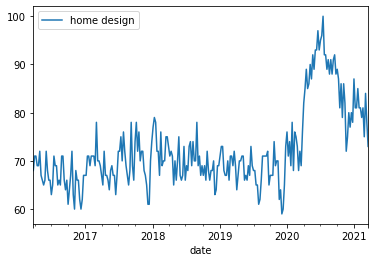

In [7]:
GetReport(['home design'], quiet=False)

In [8]:
test = Collect('surfing')

In [9]:
test

{'term': 'surfing',
 'current_popularity': 49,
 'change_3mo': '18.8%',
 'change_6mo': '26.0%',
 'change_9mo': '28.1%',
 'change_12mo': '28.8%',
 'change_24mo': '29.0%',
 'popularity_2y': 63.209678993446495,
 'sentiment': 0.19,
 'subjectivity': 0.33,
 'sentiments_std': 0.35}

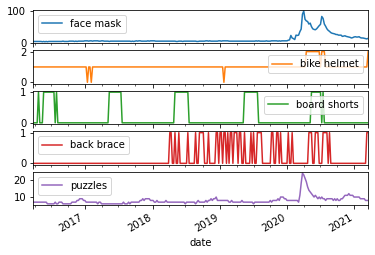

In [44]:
def PlotMany(keywords):
    ts = GetReport(keywords)
    ts.plot(subplots=True)
    
PlotMany(products)

## How can this output be improved?
plot sentiment and subjectivity rather than wrighting it out

<AxesSubplot:xlabel='date'>

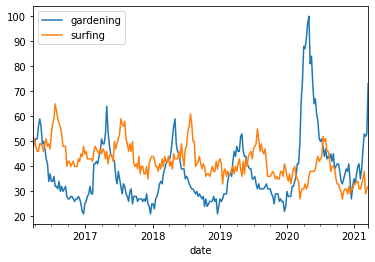

In [40]:
GetReport(['gardening', 'surfing']).plot(legend=True)